In [ ]:
pip install colorama

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import colorama
from colorama import Back, Fore, Style
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras import optimizers
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.tree import DecisionTreeRegressor
from keras.regularizers import l1, L2, l1_l2
from keras.layers import Input, Dense


%matplotlib inline


In [ ]:
data=pd.read_csv("/content/sample_data/chf_dataset.csv",header=None)
column_name=['mass_flux ','pressure',' local_equilibrium_quality','heated_tube_length','tube_equivalent_diameter','Critcal_heat_flux']
data.columns= column_name
df=pd.DataFrame(data)
df_new= pd.DataFrame(data)
df

,mass_flux,pressure,local_equilibrium_quality,heated_tube_length,tube_equivalent_diameter,Critcal_heat_flux
0,4.6,0.239,3447.5,81.50,2353.90,888.3
1,4.6,0.239,3447.5,81.50,2570.20,841.1
2,4.6,0.239,3447.5,99.50,2556.30,1197.0
3,4.6,0.239,3447.5,81.50,2365.50,812.7
4,4.6,0.239,3447.5,81.50,2291.10,781.2
...,...,...,...,...,...,...
10238,10.0,2.499,1923.6,1467.44,408.68,1757.7
10239,10.0,2.499,1827.1,1529.83,395.42,1764.0
10240,10.0,2.499,1772.0,1558.31,298.89,1757.7
10241,10.0,2.499,1675.4,1584.08,283.31,1757.7


In [ ]:
#to find the values .........
print("Shape of the dataset:",df.shape)
print("Number of samples in the dataset:",df.shape[0])
print("Number of features in the dataset:",df.shape[1])
print("data type of features:\n\n", df.dtypes)
#check the number of columns that are null values ..
print("Total Number of Null values:", df.columns[df.isnull().any()].tolist())
#print the min and max values of ech column for data preprcossing..
# List can only take the integer indices not the string..na
column_name=['mass_flux ','pressure',' local_equilibrium_quality','heated_tube_length','tube_equivalent_diameter','Critcal_heat_flux']
X= df.drop(['Critcal_heat_flux'],axis=1)
y= df['Critcal_heat_flux']
X_org_train, X_org_test, y_org_train, y_org_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
min={}
max={}
print("\n")
for i in ['mass_flux ','pressure',' local_equilibrium_quality','heated_tube_length','tube_equivalent_diameter','Critcal_heat_flux']:
  min[i]=df[i].min()
  max[i]=df[i].max()
  print(f"{Style.BRIGHT}{Fore.LIGHTBLUE_EX}Min value of {i} is:{min[i]}")
  print(f"{Style.BRIGHT}{Fore.LIGHTRED_EX}Max value of {i} is:{max[i]}\n")

Shape of the dataset: (10243, 6)
Number of samples in the dataset: 10243
Number of features in the dataset: 6
data type of features:

 mass_flux                     float64
pressure                      float64
 local_equilibrium_quality    float64
heated_tube_length            float64
tube_equivalent_diameter      float64
Critcal_heat_flux             float64
dtype: object
Total Number of Null values: []


Min value of mass_flux  is:1.0
Max value of mass_flux  is:37.5

Min value of pressure is:0.025
Max value of pressure is:3.75

Min value of  local_equilibrium_quality is:103.4
Max value of  local_equilibrium_quality is:20685.0

Min value of heated_tube_length is:9.9
Max value of heated_tube_length is:34176.2

Min value of tube_equivalent_diameter is:1.63
Max value of tube_equivalent_diameter is:7453.0

Min value of Critcal_heat_flux is:100.0
Max value of Critcal_heat_flux is:21388.5



**RELATIVE AUGMENTATION**

In [ ]:
#now we can add noise to the dataset...
def add_noise(data, noise_level=0.005):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def augment_with_noise(df, num_augmentations, noise_factor=0.01):
    augmented_data = [df]
    print(f"{Style.BRIGHT}{Fore.BLUE}No of Augmentation added:", num_augmentations)
    for _ in range(num_augmentations):
        df_noisy = df.copy()
        for col in df.columns:
            std_dev = df[col].std()
            noise_level = noise_factor * std_dev
            df_noisy[col] = add_noise(df_noisy[col], noise_level)
        augmented_data.append(df_noisy)
    return pd.concat(augmented_data, ignore_index=True)

df_noisy= augment_with_noise(df,1,0.01)
X= df_noisy.drop(['Critcal_heat_flux'],axis=1)
y= df_noisy['Critcal_heat_flux']
X_org_Aug_train, X_org_Aug_test, y_org_Aug_train, y_org_Aug_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
df_noisy.head(5)

No of Augmentation added: 1


,mass_flux,pressure,local_equilibrium_quality,heated_tube_length,tube_equivalent_diameter,Critcal_heat_flux
0,4.6,0.239,3447.5,81.5,2353.9,888.3
1,4.6,0.239,3447.5,81.5,2570.2,841.1
2,4.6,0.239,3447.5,99.5,2556.3,1197.0
3,4.6,0.239,3447.5,81.5,2365.5,812.7
4,4.6,0.239,3447.5,81.5,2291.1,781.2


**ORIGINAL AND AUGMENTED DECISION TREE REGRESSION**

In [ ]:
from numbers import Number
#Apply the Normalization technique called standard scaller..
#Apply the regression technique again to check the difference in CV error and Testing Error
# There occur a huge difference by applying the normalization technique...

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler


def Decision_tree_regression(X_train, y_train):
    Decision_tree_model = DecisionTreeRegressor()
    Decision_tree_model.fit(X_train, y_train)
    return Decision_tree_model



def Apply_Normalization(df):
  target_name = ['Critcal_heat_flux']
  feature_name = ['mass_flux ','pressure',' local_equilibrium_quality','heated_tube_length','tube_equivalent_diameter']
  feature_scaler_x = MinMaxScaler()
  target_scaler_y = MinMaxScaler()
  feature_scaler = MinMaxScaler()
  target_scaler = MinMaxScaler()

  feature_scaler_x = feature_scaler.fit(df[feature_name])
  target_scaler_y = target_scaler.fit(df[target_name])
  X = feature_scaler.fit_transform(df[feature_name])
  y = target_scaler.fit_transform(df[target_name])

  return X, y, feature_scaler_x, target_scaler_y


def Inverse_Normalization(target_scaler, y_test, y_pred):
    y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
    return y_test, y_pred

def performance_metric(X_test, X_pred):
    MSE = mean_squared_error(X_test, X_pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(X_test, X_pred)
    R_Square = r2_score(X_test, X_pred)
    return MSE, MAE, RMSE, R_Square

def Print_performance_metrics(MSE, MAE, RMSE, R_Square):
    print(f"{Style.BRIGHT}{Fore.BLUE}Mean square error:", MSE)
    print(f"{Style.BRIGHT}{Fore.BLUE}Mean Absolute error:", MAE)
    print(f"{Style.BRIGHT}{Fore.BLUE}Root Mean square error:", RMSE)
    print(f"{Style.BRIGHT}{Fore.BLUE}R square value:", R_Square)

def print_k_fold_cross_validation(MSE_score):
    print(f"{Style.BRIGHT}{Fore.BLUE}Five cross validation errors:", MSE_score)
    print(f"{Style.BRIGHT}{Fore.BLUE}Mean of five cross validation:", np.mean(MSE_score))

def Relative_Root_mean_squared_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    relative_errors = (y_true - y_pred) / y_true
    squared_relative_errors = relative_errors ** 2
    mean_squared_relative_error = np.mean(squared_relative_errors)
    rrmse = np.sqrt(mean_squared_relative_error)

    print(f"The relative root mean square error is:{rrmse}")


def Relative_X_Root_mean_squared_error(X_test, X_pred,column_name):
  sum=0

  for i in range(X_test.shape[1]):
    X_test_col=X_test[:,i]
    X_pred_col=X_pred[:,i]
    relative_errors = (X_test[i] - X_pred[i]) / X_test[i]
    squared_relative_errors = relative_errors ** 2
    mean_squared_relative_error = np.mean(squared_relative_errors)
    rrmse = np.sqrt(mean_squared_relative_error)
    sum=sum+rrmse
  print(f"The relative root mean square erroR:{sum}")

In [ ]:
def Model_Evaluation(df):
  X, y, feature_scaler, target_scaler = Apply_Normalization(df)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
  Decision_tree_model = Decision_tree_regression(X_train, y_train)

  y_pred = Decision_tree_model.predict(X_test)
  Cross_validation = cross_val_score(Decision_tree_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  MSE_Score = -Cross_validation
  MSE, MAE, RMSE, R_Square = performance_metric(y_test, y_pred)
  print_k_fold_cross_validation(MSE_Score)
  Print_performance_metrics(MSE, MAE, RMSE, R_Square)
  Relative_Root_mean_squared_error(y_test, y_pred)

  return MSE_Score, MSE, y_test, y_pred, X_test


print(f"{Style.BRIGHT}{Fore.LIGHTRED_EX}Original Decision tree Regression Performance\n\n")
MSE_Score, MSE, y_decision_test, y_decision_pred, X_decision_test=Model_Evaluation(df)
print(f"\n{Style.BRIGHT}{Fore.LIGHTMAGENTA_EX}Augmented Decision tree Regression Performance\n\n")
Aug_MSE_score, MSE, y_Aug_decision_test, y_Aug_decision_pred, X_aug_decision_test=Model_Evaluation(df_noisy)

Original Decision tree Regression Performance


Five cross validation errors: [0.00065508 0.00109664 0.00089511 0.00127023 0.00162671]
Mean of five cross validation: 0.0011087540815237099
Mean square error: 0.0011106028514639512
Mean Absolute error: 0.01010605503263384
Root Mean square error: 0.03332570856656991
R square value: 0.8816706603652461
The relative root mean square error is:6.240530611766209

Augmented Decision tree Regression Performance


Five cross validation errors: [0.00097494 0.00100131 0.00059135 0.00114713 0.00049301]
Mean of five cross validation: 0.0008415464341588873
Mean square error: 0.000759875613704863
Mean Absolute error: 0.007848213100917878
Root Mean square error: 0.02756584142929185
R square value: 0.9162093139800276
The relative root mean square error is:4.914941957409248


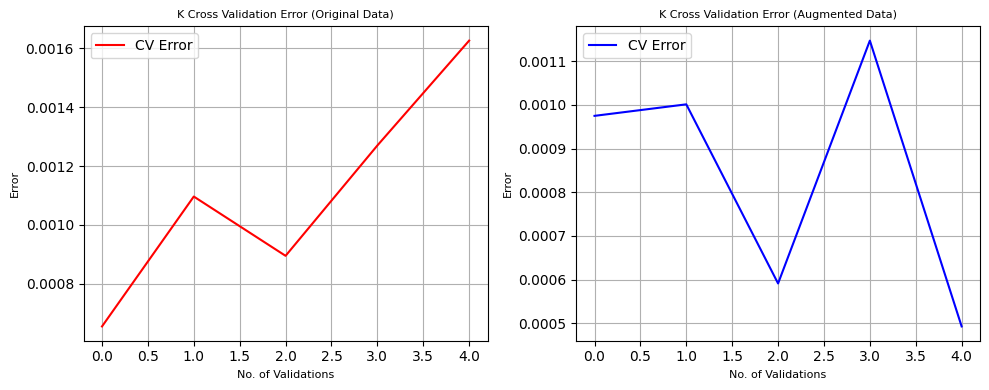

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

def Plot_Visualization(j, score, color, row_title):
    # Ensure row is within the valid range
    if j not in [0, 1]:
        raise ValueError("Row index must be 0 or 1")

    # Plotting CV Error
    ax[j].plot(score['MSE_Score'], color=color, label="CV Error")
    ax[j].set_title(f"K Cross Validation Error ({row_title})",fontsize=8)
    ax[j].set_xlabel("No. of Validations",fontsize=8)
    ax[j].set_ylabel("Error",fontsize=8)
    ax[j].legend()
    ax[j].grid(True)



Plot_Visualization(0, score={'MSE_Score': MSE_Score}, color='red', row_title="Original Data")
Plot_Visualization(1, score={'MSE_Score': Aug_MSE_score}, color='blue', row_title="Augmented Data")

plt.tight_layout()
plt.show()

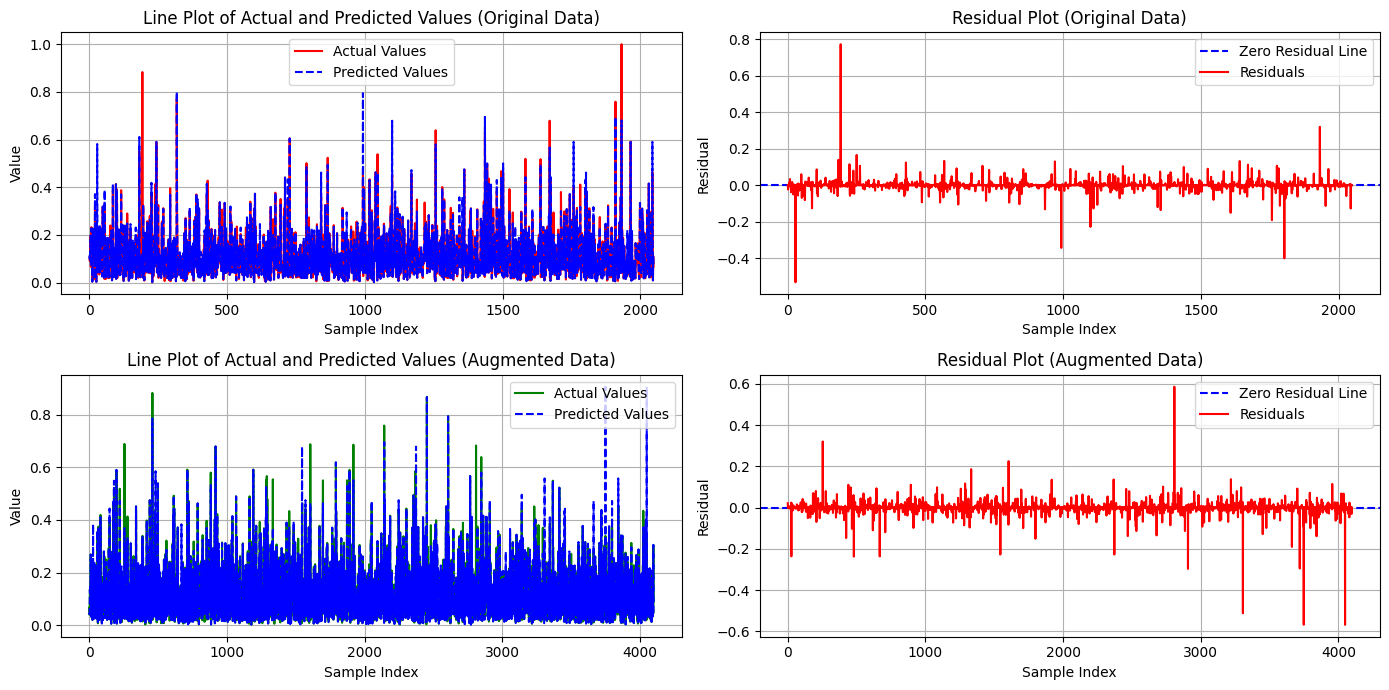

In [ ]:
y_decision_test= np.array(y_decision_test).flatten()
y_decision_pred= np.array(y_decision_pred).flatten()
y_Aug_decision_test= np.array(y_Aug_decision_test).flatten()
y_Aug_decision_pred= np.array(y_Aug_decision_pred).flatten()
#now we can draw for the testing and predicting ....
fig, ax = plt.subplots(2, 2, figsize=(14, 7))

Org_y= pd.DataFrame({'Actual': y_decision_test, 'Predicted': y_decision_pred})
Org_y['Residual'] = Org_y['Actual'] - Org_y['Predicted']


Aug_y = pd.DataFrame({'Actual': y_Aug_decision_test, 'Predicted': y_Aug_decision_pred})
Aug_y['Residual'] = Aug_y['Actual'] - Aug_y['Predicted']


def Scatter_Plot(row, actual, predicted, residuals, color, row_title):
    # Plot actual vs. predicted values
    ax[row, 0].plot(actual, color=color[0], label='Actual Values', alpha=1)
    ax[row, 0].plot(predicted, color=color[1], linestyle='--', label='Predicted Values', alpha=1)
    ax[row, 0].set_xlabel('Sample Index')
    ax[row, 0].set_ylabel('Value')
    ax[row, 0].set_title(f'Line Plot of Actual and Predicted Values ({row_title})')
    ax[row, 0].legend()
    ax[row, 0].grid(True)

    # Plot residuals
    ax[row, 1].axhline(0, color=color[1], linestyle='--', label='Zero Residual Line')
    ax[row, 1].plot(residuals, color='red', label='Residuals')
    ax[row, 1].set_xlabel('Sample Index')
    ax[row, 1].set_ylabel('Residual')
    ax[row, 1].set_title(f'Residual Plot ({row_title})')
    ax[row, 1].legend()
    ax[row, 1].grid(True)


Scatter_Plot(row=0, actual=y_decision_test, predicted=y_decision_pred, residuals=Org_y['Residual'], color=['red', 'blue'], row_title='Original Data')

Scatter_Plot(row=1, actual=y_Aug_decision_test, predicted=y_Aug_decision_pred, residuals=Aug_y['Residual'], color=['green', 'blue'], row_title='Augmented Data')

plt.tight_layout()
plt.show()

In [ ]:
#Apply the auto encoder technique..
#test it with different epochs ...
#test it with different optimizer values and optimizer technique..
#used the cross validation technique for more robustness the model..
from keras.layers import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model

np.random.seed(42)
tf.random.set_seed(42)
input_size= X.shape[1]
Input_Layer_size= [100,50,15]

In [ ]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import KFold

def Encoder_Decoder_Model(input_size, Input_Layer_size):
    Input_Layer = Input(shape=(input_size,))
    Enc_Layer_1 = Dense(Input_Layer_size[0], activation='relu')(Input_Layer)
    Enc_Layer_2 = Dense(Input_Layer_size[1], activation='relu')(Enc_Layer_1)
    Latent_Layer = Dense(Input_Layer_size[2], activation='relu')(Enc_Layer_2)
    Dec_Layer_1 = Dense(Input_Layer_size[1], activation='relu')(Latent_Layer)
    Dec_Layer_2 = Dense(Input_Layer_size[0], activation='relu')(Dec_Layer_1)
    Output_Layer = Dense(input_size, activation='linear')(Dec_Layer_2)

    Auto_Encoder = Model(Input_Layer, Output_Layer)
    Auto_Encoder.compile(optimizer=Adam(0.00001), loss="mean_squared_error")
    return Auto_Encoder

def k_fold_cross_validation_Technique(X, input_size, input_layer_size, k, epochs, batch_size):
    # Convert X to a NumPy array if it's a DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values

    Kf = KFold(n_splits=k, shuffle=True, random_state=42)
    val_losses = []

    for train_index, val_index in Kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        model = Encoder_Decoder_Model(input_size, input_layer_size)
        history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, X_val), verbose=1)
        val_loss = model.evaluate(X_val, X_val, verbose=0)
        val_losses.append(val_loss)

    mean_val_loss = np.mean(val_losses)
    return mean_val_loss, val_losses, model

**SIMPLE AUTO-ENCODER TRAINING**

In [ ]:
X, y, feature_scaler, target_scaler = Apply_Normalization(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
mean_value_loss, Validation_losses, Auto_Encoder = k_fold_cross_validation_Technique(X, input_size, Input_Layer_size, 5, 15, 15)

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0616 - val_loss: 0.0424
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0337 - val_loss: 0.0219
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0196 - val_loss: 0.0181
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0164 - val_loss: 0.0145
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0127 - val_loss: 0.0106
Epoch 6/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 7/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 8/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 9/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 11/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 12/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/ste

**AUGMENTED AUTO-ENCODER TRAINING**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
Aug_X, Aug_y, Aug_feature_scaler, Aug_target_scaler = Apply_Normalization(df_noisy)

X_Aug_train, X_Aug_test, y_Aug_train, y_Aug_test = train_test_split(Aug_X, Aug_y, test_size=0.2, random_state=42, shuffle=True)
Aug_mean_loss, Aug_Validation_losses, Aug_Auto_Encoder = k_fold_cross_validation_Technique(Aug_X, input_size, Input_Layer_size, 5, 10, 15)

Epoch 1/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0607 - val_loss: 0.0230
Epoch 2/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0201 - val_loss: 0.0128
Epoch 3/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0110 - val_loss: 0.0069
Epoch 4/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 5/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 6/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 7/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 8/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0011 - val_loss: 6.5169e-04
Epoch 9/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1781e-04 - val_loss: 3.9798e-04
Epoch 10/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.1674e-04 - val_loss: 2.6033e-04
Epoch 1/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0615 - val_loss: 0.0246
Epoch 2/10


**ORIGINAL AUTO ENCODER SUMMARY**

In [ ]:
Auto_Encoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 100)                 │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 15)                  │             765 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 50)                  │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,462 (150.25 KB)

 Trainable params: 12,820 (50.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,642 (100.17 KB)

In [ ]:
from sklearn.metrics import mean_absolute_error
def Performance_Evaluation(X_test, X_pred):
  # Compute performance metrics
  MSE, MAE, RMSE, R_Square = performance_metric(X_test,X_pred)
  Print_performance_metrics(MSE, MAE, RMSE, R_Square)
  Relative_X_Root_mean_squared_error(X_test, X_pred,column_name)


print(f"{Style.BRIGHT}{Fore.LIGHTRED_EX}Original Auto-Encoder Performance\n\n")
X_pred = Auto_Encoder.predict(X_test)
Performance_Evaluation(X_test, X_pred)
X_Aug_pred=  Aug_Auto_Encoder.predict(X_Aug_test)
print(f"\n{Style.BRIGHT}{Fore.LIGHTMAGENTA_EX}Augmented Auto-Encoder Performance\n\n")
Performance_Evaluation(X_Aug_test, X_Aug_pred)

Original Auto-Encoder Performance


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean square error: 0.0007053550447493777
Mean Absolute error: 0.015332088504291297
Root Mean square error: 0.02655852113257396
R square value: 0.9078382064559488
The relative root mean square erroR:1.1090862593941713
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Augmented Auto-Encoder Performance


Mean square error: 0.00029058112254927844
Mean Absolute error: 0.008802617634072984
Root Mean square error: 0.01704644017234327
R square value: 0.9402069559908494
The relative root mean square erroR:4.780838574409292


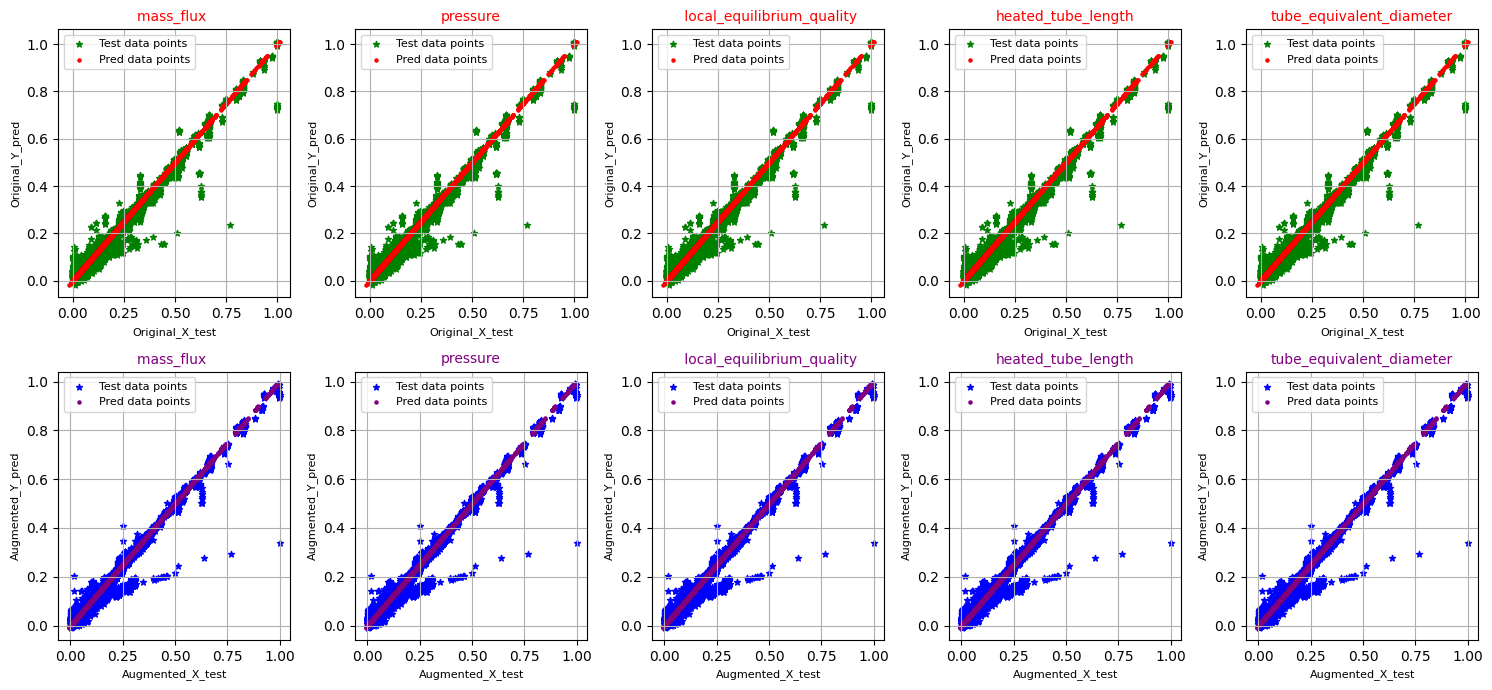

In [ ]:
import matplotlib.pyplot as plt


columns_name = ['mass_flux ', 'pressure', ' local_equilibrium_quality',
                'heated_tube_length', 'tube_equivalent_diameter']

# Create a figure and an array of subplots
fig, ax = plt.subplots(2, len(columns_name), figsize=(15, 7))

def Feature_Visualization(ax,j , columns_name, X_test, X_pred, color, row_title):
    for i, column in enumerate(columns_name):
        ax[j, i].scatter(X_test, X_pred, color=color[0], label='Test data points',  s=20, marker="*")
        ax[j, i].scatter(X_pred, X_pred, color=color[1], label='Pred data points', s=20, marker=".")
        ax[j, i].set_title(f"{column}", fontsize=10, color=color[1])
        ax[j, i].set_xlabel(f"{row_title}X_test", fontsize=8)
        ax[j, i].set_ylabel(f"{row_title}Y_pred", fontsize=8)
        ax[j, i].legend(fontsize=8)
        ax[j, i].grid(True)


Feature_Visualization(ax, 0, columns_name, X_test, X_pred, color=['green', 'red'], row_title='Original_')
Feature_Visualization(ax, 1, columns_name, X_Aug_test, X_Aug_pred, color=['blue','Purple'], row_title='Augmented_')
plt.tight_layout()
plt.show()


**RECONSTRUCTED ERROR COMPARISON**

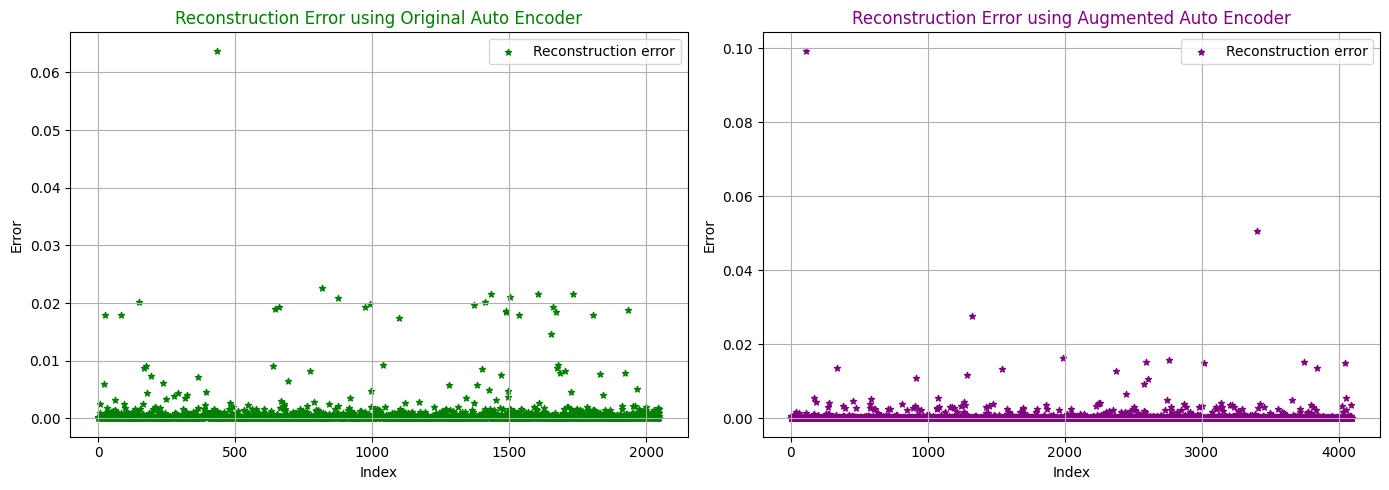

In [ ]:
#now check its reconstructed error..
Reconstructed_error = np.mean((X_test-X_pred)**2, axis=1)
Reconstructed_df= pd.DataFrame({'Reconstructed Error': Reconstructed_error})

Aug_Reconstructed_error = np.mean((X_Aug_test - X_Aug_pred)**2, axis=1)
Aug_Reconstructed_df= pd.DataFrame({'Reconstructed Error': Aug_Reconstructed_error})

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

def Reconstructed_error(ax, j, Reconstructed_df, color, row_title):
    ax[j].scatter(Reconstructed_df.index, Reconstructed_df['Reconstructed Error'], color=color[0], label="Reconstruction error", s=20, marker='*')
    ax[j].set_title(f"Reconstruction Error using {row_title} Auto Encoder",color=color[0])
    ax[j].set_xlabel("Index")
    ax[j].set_ylabel("Error")
    ax[j].legend()
    ax[j].grid(True)

# Plot the reconstruction errors
Reconstructed_error(ax, 0, Reconstructed_df, color=['green'], row_title='Original')
Reconstructed_error(ax, 1, Aug_Reconstructed_df, color=['Purple'], row_title='Augmented')

plt.tight_layout()
plt.show()

**AUTO-ENCODER WITH DECISION TREE REGRESSION**

In [ ]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from keras import regularizers
from keras.regularizers import L2
np.random.seed(42)

def Auto_Encoder_with_Decision_tree_regressor(input_size, Input_Layer_size):
    Input_Layer = Input(shape=(input_size,))
    Enc_Layer_1 = Dense(Input_Layer_size[0], activation='relu', activity_regularizer=regularizers.L2(0.0001))(Input_Layer)
    Enc_Layer_2 = Dense(Input_Layer_size[1], activation='relu', activity_regularizer=regularizers.L2(0.0001))(Enc_Layer_1)
    Latent_Layer = Dense(Input_Layer_size[2], activation='relu', activity_regularizer=regularizers.L2(0.0001))(Enc_Layer_2)
    Dec_Layer_1 = Dense(Input_Layer_size[1], activation='relu', activity_regularizer=regularizers.L2(0.0001))(Latent_Layer)
    Dec_Layer_2 = Dense(Input_Layer_size[0], activation='relu', activity_regularizer=regularizers.L2(0.0001))(Dec_Layer_1)
    Output_Layer = Dense(input_size, activation='linear')(Dec_Layer_2)

    Auto_Encoder_Regression = Model(Input_Layer, Output_Layer)
    Auto_Encoder_Regression.compile(optimizer=Adam(0.0001), loss="mean_squared_error")
    return Auto_Encoder_Regression, Input_Layer, Latent_Layer


def k_fold_Aug_cross_validation_Technique(X, input_size, input_layer_size, k, epochs, batch_size):
    # Convert X to a NumPy array if it's a DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values

    Kf = KFold(n_splits=k, shuffle=True, random_state=42)
    Aug_val_losses = []

    for train_index, val_index in Kf.split(X):
        Aug_X_train, Aug_X_val = X[train_index], X[val_index]
        model,Input_layer,Latent_Layer = Auto_Encoder_with_Decision_tree_regressor(input_size, input_layer_size)
        history = model.fit(Aug_X_train, Aug_X_train, epochs=epochs, batch_size=batch_size,
                            validation_data=(Aug_X_val, Aug_X_val), verbose=1)
        Aug_val_loss = model.evaluate(Aug_X_val, Aug_X_val, verbose=0)
        Aug_val_losses.append(Aug_val_loss)

    Aug_mean_loss = np.mean(Aug_val_losses)
    return model, Aug_val_losses, Aug_mean_loss, Input_layer, Latent_Layer

**AUTO-ENCODER WITH DECISION TREE REGRESSION TRAINING**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
Reg_X, Reg_y, feature_scaler, target_scaler = Apply_Normalization(df)
Reg_Auto_Encoder,Reg_Validation_losses,Reg_mean_loss,input_Layer,latent_Layer = k_fold_Aug_cross_validation_Technique(Reg_X, input_size,Input_Layer_size,
                                                                                                                      5, 15, 15)

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0382 - val_loss: 0.0073
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.3612e-04 - val_loss: 8.4547e-04
Epoch 7/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.7160e-04 - val_loss: 7.1619e-04
Epoch 8/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.5775e-04 - val_loss: 6.1712e-04
Epoch 9/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.6914e-04 - val_loss: 5.3975e-04
Epoch 10/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9840e-04 - val_loss: 4.7519e-04
Epoch 11/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3972e-04 - val_loss: 4.2313e-04
Epoc

***`*AUGMENTED AUTO-ENCODER WIT DECISION TREE REGRESSION TRAINING *`***

In [ ]:
from sklearn.tree import DecisionTreeRegressor
Reg_Aug_X, Reg_Aug_y, Aug_feature_scaler, Aug_target_scaler = Apply_Normalization(df_noisy)

Reg_Auto_Encoder,Reg_Validation_losses,Reg_mean_loss,Aug_Input_Layer,Aug_Latent_Layer = k_fold_Aug_cross_validation_Technique(Reg_Aug_X, input_size,
 Input_Layer_size, 5, 20, 12)

Epoch 1/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0218 - val_loss: 0.0019
Epoch 2/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0015 - val_loss: 8.3490e-04
Epoch 3/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.3699e-04 - val_loss: 5.3061e-04
Epoch 4/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.8816e-04 - val_loss: 3.8479e-04
Epoch 5/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.5933e-04 - val_loss: 2.9714e-04
Epoch 6/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.8018e-04 - val_loss: 2.4390e-04
Epoch 7/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.2986e-04 - val_loss: 2.0526e-04
Epoch 8/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.9500e-04 - val_loss: 1.7888e-04
Epoch 9/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.6979e-04 - val_loss: 1.5829e-04
Epoch 10/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.5027e-04 - val_loss: 1.4282e-04
Epoch 11/20
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/s

In [ ]:
from sklearn.tree import DecisionTreeRegressor
Reg_Model = DecisionTreeRegressor()
def Performance_Evaluation(Aug_Input_Layer, Aug_Latent_Layer,Reg_X, Reg_y):
  Encoder = Model(Aug_Input_Layer, Aug_Latent_Layer)
  Latent_representation = Encoder.predict(Reg_X)
  X_Train, X_Test, y_Train, y_Test = train_test_split(Latent_representation, Reg_y, test_size=0.2, shuffle=True, random_state=42)
  Reg_Model.fit(X_Train, y_Train)
  y_prediction = Reg_Model.predict(X_Test)
  MSE, MAE, RMSE, R_Square = performance_metric(y_Test,y_prediction)
  Print_performance_metrics(MSE, MAE, RMSE, R_Square)
  Relative_Root_mean_squared_error(y_Test, y_prediction)
  return y_Test, y_prediction, X_test




print(f"{Style.BRIGHT}{Fore.LIGHTRED_EX}Original Auto-Encoder with Decision tree regression Performance\n\n")
y_AE_DEC_test, y_AE_DEC_prediction, X_AE_DEC_Test= Performance_Evaluation(input_Layer,latent_Layer,Reg_X, Reg_y)

print(f"\n{Style.BRIGHT}{Fore.LIGHTMAGENTA_EX}Augmented Auto-Encoder with Decision tree regression Performance\n\n")
y_Aug_AE_DEC_Test, y_Aug_AE_DEC_Pred, X_Aug_AE_DEC_test= Performance_Evaluation(Aug_Input_Layer, Aug_Latent_Layer, Reg_Aug_X,Reg_Aug_y)

Original Auto-Encoder with Decision tree regression Performance


321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean square error: 0.0011810941786374028
Mean Absolute error: 0.013063083453059194
Root Mean square error: 0.03436705077014032
R square value: 0.8741601518306995
The relative root mean square error is:6.166575249088942

Augmented Auto-Encoder with Decision tree regression Performance


641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean square error: 0.0005793060529041587
Mean Absolute error: 0.007367339326954466
Root Mean square error: 0.02406877755317371
R square value: 0.9361205298434343
The relative root mean square error is:4.89015404538183


**SCATTER PLOT COMPARISON OF ORIGINLA AND AUGMENETED AUTO-ENCODER WITH DECISION TREE REGRESSION**

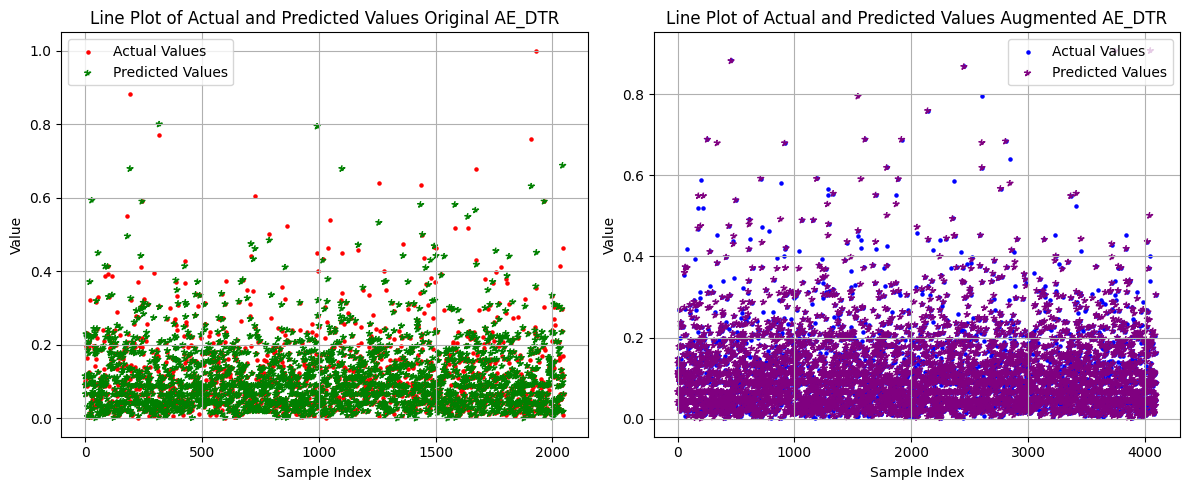

In [ ]:
from re import S
#now we can draw for the testing and predicting ....
fig, ax= plt.subplots(1, 2, figsize=(12, 5))

def Scatter_plot(ax, j, y_Test, y_prediction, color, row_title):
    ax[j].scatter(range(len(y_Test)), y_Test, color=color[0], label='Actual Values', marker='.', s=20)
    ax[j].scatter(range(len(y_prediction)), y_prediction, color=color[1], linestyle='--', label='Predicted Values',marker='*', s=20)
    ax[j].set_xlabel('Sample Index')
    ax[j].set_ylabel('Value')
    ax[j].set_title(f'Line Plot of Actual and Predicted Values {row_title}')
    ax[j].legend()
    ax[j].grid(True)

Scatter_plot(ax, 0, y_AE_DEC_test, y_AE_DEC_prediction, color=['red', 'green'], row_title='Original AE_DTR')
Scatter_plot(ax, 1, y_Aug_AE_DEC_Test, y_Aug_AE_DEC_Pred, color=['blue', 'purple'], row_title='Augmented AE_DTR')

plt.tight_layout()
plt.show()

***`*FEATURES VALUES VS CRITICAL HEAT FLUX RELATIVE DEVIAITON *`***

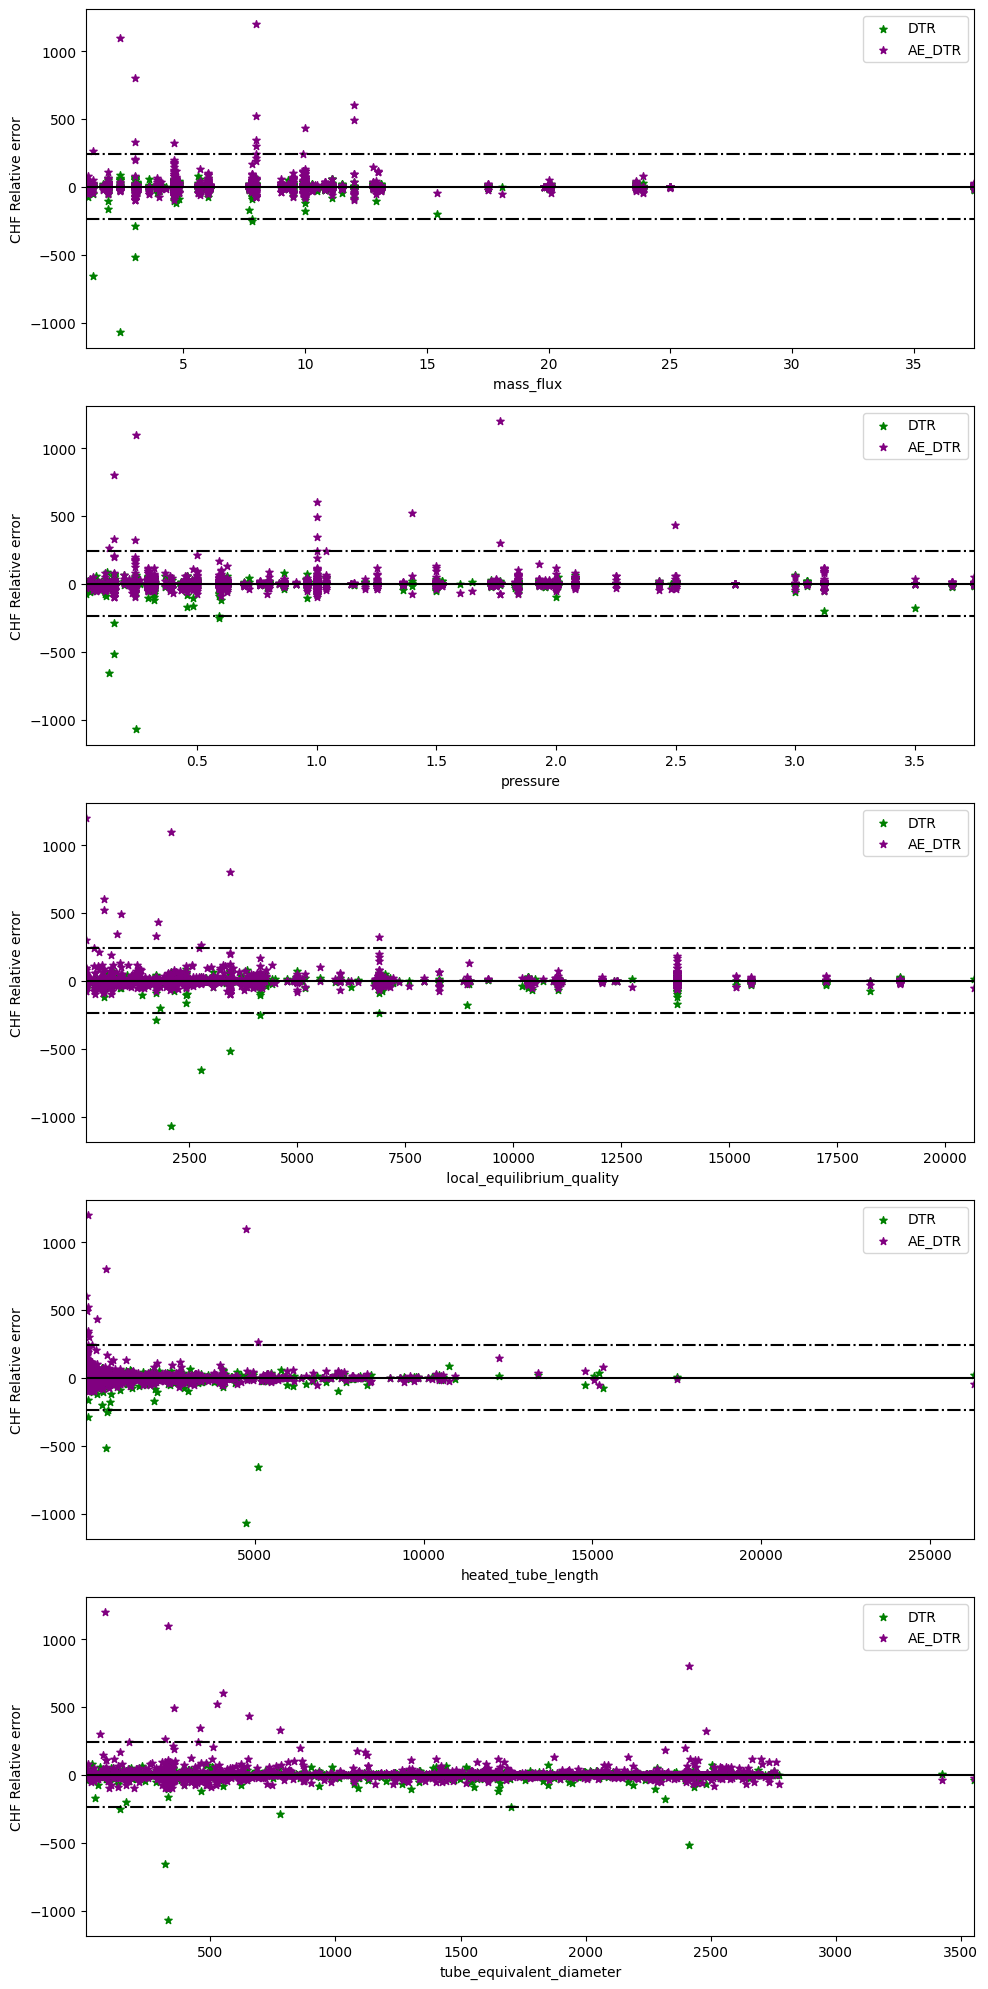

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import builtins
name=['mass_flux ','pressure',' local_equilibrium_quality','heated_tube_length','tube_equivalent_diameter']
X_test_df = pd.DataFrame(X_org_test, columns=name)

fig, ax = plt.subplots(len(name), 1, figsize=(10, 20))

def CHF_and_Feature_plot(ax, df_value, Relative_dev, colors):
  max_deviation = builtins.max(np.max(np.abs(Relative_dev[0])), np.max(np.abs(Relative_dev[1])))
  upper_bound = 0.2 * max_deviation
  lower_bound = -0.2 * max_deviation
  for i, column in enumerate(name):
    feature_values = np.array(df_value[column]).flatten()

    ax[i].scatter(feature_values, Relative_dev[0], color=colors[0], marker='*', label='DTR', alpha=1, s=30)
    ax[i].scatter(feature_values, Relative_dev[1], color=colors[1], marker='*', label='AE_DTR', alpha=1, s=30)

    ax[i].set_xlabel(column)
    ax[i].set_ylabel('CHF Relative error')
    ax[i].legend()

    ax[i].set_xlim([np.min(feature_values), np.max(feature_values)])
    ax[i].axhline(y=0, color='black', linestyle='solid', label='y=0')  # Line at y=0
    ax[i].axhline(y=upper_bound, color='black', linestyle='dashdot', label='+20%')  # Line at +20% of max deviation
    ax[i].axhline(y=lower_bound, color='black', linestyle='dashdot', label='-20%')  # Line at -20% of max deviation




y_AE_DEC_prediction=np.array(y_AE_DEC_prediction).flatten()
y_AE_DEC_test=np.array(y_AE_DEC_test).flatten()
DTR_Relative_Dev= ((y_decision_test-y_decision_pred)/(y_decision_test))*100
AE_DTR_Relative_Dev= ((y_AE_DEC_prediction-y_AE_DEC_test)/(y_AE_DEC_test))*100
DTR_Relative_Dev = np.array(DTR_Relative_Dev).flatten()
AE_DTR_Relative_Dev = np.array(AE_DTR_Relative_Dev).flatten()

CHF_and_Feature_plot(ax, X_test_df, [DTR_Relative_Dev, AE_DTR_Relative_Dev], colors=['green', 'purple'])
plt.tight_layout()
plt.show()


**AUTO-ENCODER WITH RANDOM FOREST REGRESSION**

In [ ]:
#Now we can apply the random forest with grid search , using multiple trees, using max depth, using classifier ..
import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
Regr_Tree_model = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',  # or 'mae'
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,  # Use 1 instead of None
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=42,
    max_samples=None
)



**MODEL PERFORMANCE WITH AUTO-ENCODER RANDOM FOREST REGRESSION**

In [ ]:
def Performance_Evaluation(Aug_Input_Layer, Aug_Latent_Layer, Reg_X, Reg_y):
  Encoder = Model(Aug_Input_Layer, Aug_Latent_Layer)
  Latent_representation = Encoder.predict(Reg_X)
  X_Train, X_Test, y_Train, y_Test = train_test_split(Latent_representation, Reg_y, test_size=0.2, shuffle=True, random_state=42)
  Regr_Tree_model.fit(X_Train, y_Train)
  y_prediction = Regr_Tree_model.predict(X_Test)
  MSE, MAE, RMSE, R_Square = performance_metric(y_Test,y_prediction)
  Print_performance_metrics(MSE, MAE, RMSE, R_Square)
  Relative_Root_mean_squared_error(y_Test, y_prediction)
  return y_Test, y_prediction, X_test




print(f"{Style.BRIGHT}{Fore.LIGHTRED_EX} Original Auto-Encoder with Random forest regression\n")
y_RF_test, y_RF_pred, X_RF_test= Performance_Evaluation(input_Layer,latent_Layer,Reg_X, Reg_y)

print(f"\n{Style.BRIGHT}{Fore.LIGHTMAGENTA_EX}Augmented Auto-Encoder with Random forest regression\n")
y_Aug_RF_test, y_Aug_RF_pred, X_Aug_RF_test= Performance_Evaluation(Aug_Input_Layer, Aug_Latent_Layer, Reg_Aug_X,Reg_Aug_y)

 Original Auto-Encoder with Random forest regression

321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean square error: 0.0008764584193194955
Mean Absolute error: 0.011746230039234867
Root Mean square error: 0.029605040437727752
R square value: 0.9066176123726958
The relative root mean square error is:6.055848862839357

Augmented Auto-Encoder with Random forest regression

641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean square error: 0.00037611643604161386
Mean Absolute error: 0.007434048466709534
Root Mean square error: 0.01939372156244422
R square value: 0.958526035536713
The relative root mean square error is:4.79079989991371


**Scatter Plot Of Decision Tree, Auto-Encoder With Decision Regression And Auto-Encoder With Random Forest Regression For Original Dataset**

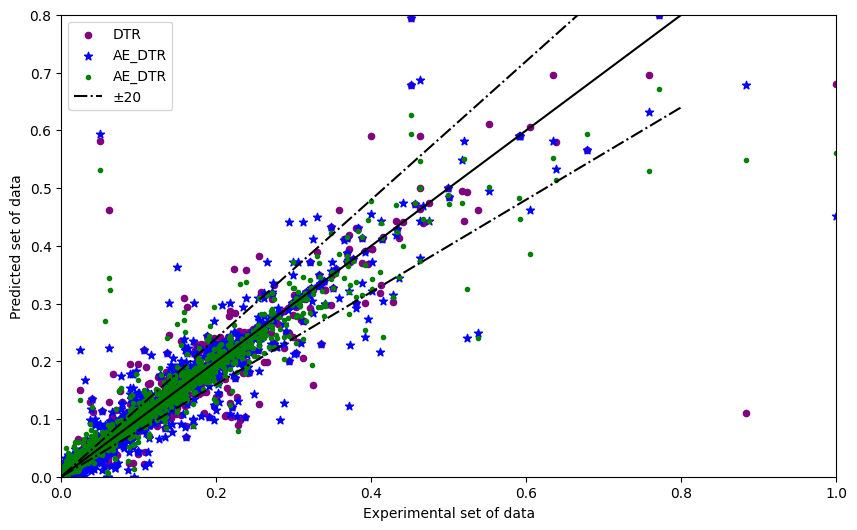

In [ ]:
# Now calculate the predicted vs experimental CHF for decision tree regression and decision tree regression for augmentation..
import builtins
import matplotlib.pyplot as plt

def Comparitive_Scatter_Plot(y_Dec_test, y_Dec_pred, y_AE_Dec_test, y_AE_Dec_pred,y_AE_RFR_test,y_AE_RFR_pred, color, label):
  plt.figure(figsize=(10, 6))
  plt.scatter(y_Dec_test, y_Dec_pred, color=color[0],label=label[0], alpha=1, marker='o', s=20)
  plt.scatter(y_AE_Dec_test, y_AE_Dec_pred, color=color[1], label=label[1], alpha=1, marker='*')
  plt.scatter(y_AE_RFR_test, y_AE_RFR_pred, color=color[2], label=label[1], alpha=1, marker='.')

  plt.plot([builtins.min(y_Dec_test), builtins.max(y_Dec_pred)],
             [builtins.min(y_Dec_test), builtins.max(y_Dec_pred)], color='Black', linestyle='solid')


  plt.plot([builtins.min(y_Dec_test), builtins.max(y_Dec_pred)],
             [1.2 * builtins.min(y_Dec_test), 1.2 * builtins.max(y_Dec_pred)], color='black', label='±20', linestyle='dashdot')

  plt.plot([builtins.min(y_Dec_test), builtins.max(y_Dec_pred)],
             [0.8 * builtins.min(y_Dec_test), 0.8 * builtins.max(y_Dec_pred)], color='black', linestyle='dashdot')

  plt.xlabel("Experimental set of data", fontsize=10)
  plt.ylabel("Predicted set of data", fontsize=10)
  plt.xlim(0, builtins.max(y_Dec_test))
  plt.ylim(0, builtins.max(y_Dec_pred))


  plt.legend()
  plt.show()


y_RF_test=np.array(y_RF_test).flatten()
y_RF_pred=np.array(y_RF_pred).flatten()
Comparitive_Scatter_Plot(y_decision_test, y_decision_pred, y_AE_DEC_test,y_AE_DEC_prediction, y_RF_test, y_RF_pred, color=['purple','blue','green'], label=['DTR', 'AE_DTR','AE_RFR'])

**Scatter Plot Of Decision Tree, Auto-Encoder With Decision Regression And Auto-Encoder With Random Forest Regression For Augmeneted Dataset**

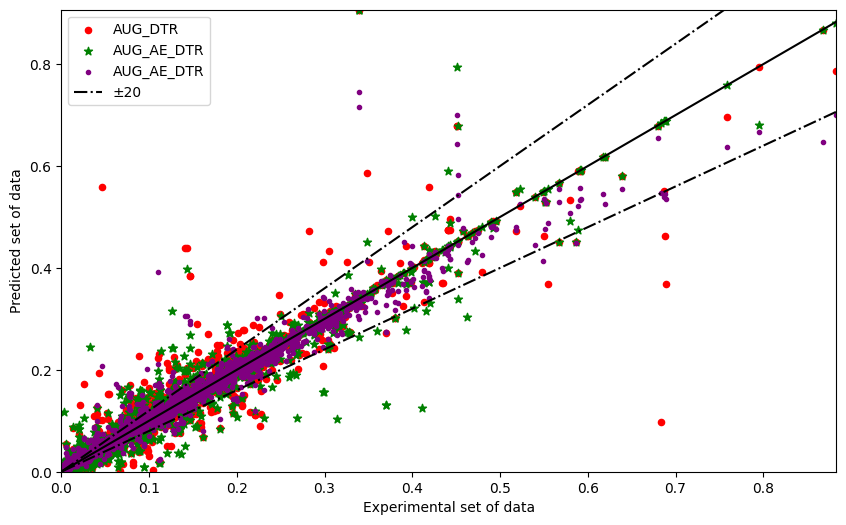

In [ ]:
y_Aug_RF_test=np.array(y_Aug_RF_test).flatten()
y_Aug_RF_pred=np.array(y_Aug_RF_pred).flatten()
y_Aug_AE_DEC_Test=np.array(y_Aug_AE_DEC_Test).flatten()
y_Aug_AE_DEC_Pred= np.array(y_Aug_AE_DEC_Pred).flatten()
Comparitive_Scatter_Plot(y_Aug_decision_test, y_Aug_decision_pred, y_Aug_AE_DEC_Test, y_Aug_AE_DEC_Pred, y_Aug_RF_test, y_Aug_RF_pred, color=['red','green','purple'], label=['AUG_DTR', 'AUG_AE_DTR','AUG_AE_RFR'])

**SAMPLES WITHIN  ± 10% AND  ± 20% ERROR FOR ORIGINAL DATASET**

In [ ]:
#Now i want to calcualte that how much predicted data occur in the 10% deviation error and 20% deviation error..
#calculate the percentage of samples that have less than 10 and 20 percent of error ....
DTR_Relative_Dev= np.abs((y_decision_pred-y_decision_test)/y_decision_test)*100
AE_DTR_Relative_Dev=np.abs((y_AE_DEC_prediction-y_AE_DEC_test)/y_AE_DEC_test)*100
AE_RF_Relative_Dev=np.abs((y_RF_pred-y_RF_test)/y_RF_test)*100
def Samples_Percentage(Relative_dev, title):
  samples=[]
  New_samples=[]
  for i in range(len(Relative_dev)):
    if Relative_dev[i]<=10:
      samples.append(Relative_dev[i])
    if Relative_dev[i]<=20:
      New_samples.append(Relative_dev[i])


  Percentage = (len(samples) / len(Relative_dev)) * 100
  New_percentage = (len(New_samples) / len(Relative_dev)) * 100
  print(f"{Style.BRIGHT}{Fore.BLUE}Samples within ± 10% error for {title}:{Percentage}")
  print(f"{Style.BRIGHT}{Fore.BLUE}Samples within ± 20% error for {title}:{New_percentage}")

Samples_Percentage(DTR_Relative_Dev, title='DTR')
Samples_Percentage(AE_DTR_Relative_Dev, title='AE_DTR')
Samples_Percentage(AE_RF_Relative_Dev, title='AE_RF')

Samples within ± 10% error for DTR:77.25719863347975
Samples within ± 20% error for DTR:87.7989263055149
Samples within ± 10% error for AE_DTR:67.88677403611518
Samples within ± 20% error for AE_DTR:78.62371888726209
Samples within ± 10% error for AE_RF:67.15470961444608
Samples within ± 20% error for AE_RF:82.3816495851635


**SAMPLES WITHIN  ± 10% AND  ± 20% ERROR FOR AUGMENTED DATASET**

In [ ]:
Aug_DTR_Relative_Dev= np.abs((y_Aug_decision_test-y_Aug_decision_pred)/y_Aug_decision_test)*100
Aug_AE_DTR_Relative_Dev=np.abs((y_Aug_AE_DEC_Pred- y_Aug_AE_DEC_Test)/ y_Aug_AE_DEC_Test)*100
Aug_AE_RF_Relative_Dev=np.abs((y_Aug_RF_pred-y_Aug_RF_test)/y_Aug_RF_test)*100

Samples_Percentage(Aug_DTR_Relative_Dev, title='Aug_DTR')
Samples_Percentage(Aug_AE_DTR_Relative_Dev, title='Aug_AE_DTR')
Samples_Percentage(Aug_AE_RF_Relative_Dev, title='Aug_AE_RF')

Samples within ± 10% error for Aug_DTR:80.86871644704733
Samples within ± 20% error for Aug_DTR:89.36066373840899
Samples within ± 10% error for Aug_AE_DTR:81.35675939482675
Samples within ± 20% error for Aug_AE_DTR:88.09175207418252
Samples within ± 10% error for Aug_AE_RF:78.3552952659834
Samples within ± 20% error for Aug_AE_RF:89.11664226451927
